<a href="https://colab.research.google.com/github/maritnorli/IFCB_CNN_Classify/blob/main/Train_test_IFCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'2.1.0+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "IFCB_test_train"
#image_path = data_path

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)



data/IFCB_test_train does not exist, creating one...


In [4]:
# Download data from PUBLIC repository
# When zipping files, zip those inside the parent forlder (mark Test and Train and then zip those to IFCB_test_train.zip) otherwise its
# too many folders in the path for a simple setup
with open(data_path / "IFCB_test_train.zip", "wb") as f: #data path= image_path  SLASH the file we are trying to open
  request = requests.get("https://github.com/maritnorli/IFCB_CNN_Classify/raw/main/data/IFCB_test_train.zip")
  print("Downloading IFCB data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "IFCB_test_train.zip", "r") as zip_ref:
  print("Unzipping IFCB_test_train data...")
  zip_ref.extractall(image_path)

Unzipping IFCB_test_train data...


## 2. Becoming one with the data (data prep and data explore)


In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [26]:
walk_through_dir(image_path)

There are 1 directories and 0 images in 'data/IFCB_test_train'.
There are 2 directories and 0 images in 'data/IFCB_test_train/IFCB_test_train'.
There are 3 directories and 0 images in 'data/IFCB_test_train/IFCB_test_train/Train'.
There are 0 directories and 70 images in 'data/IFCB_test_train/IFCB_test_train/Train/Chaetoceros_decipiens_118'.
There are 0 directories and 70 images in 'data/IFCB_test_train/IFCB_test_train/Train/Tripos_muelleri_008'.
There are 0 directories and 70 images in 'data/IFCB_test_train/IFCB_test_train/Train/Guinardia_delicatula_095'.
There are 3 directories and 0 images in 'data/IFCB_test_train/IFCB_test_train/Test'.
There are 0 directories and 14 images in 'data/IFCB_test_train/IFCB_test_train/Test/Chaetoceros_decipiens_118'.
There are 0 directories and 14 images in 'data/IFCB_test_train/IFCB_test_train/Test/Tripos_muelleri_008'.
There are 0 directories and 14 images in 'data/IFCB_test_train/IFCB_test_train/Test/Guinardia_delicatula_095'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "Train"
test_dir = image_path / "Test"

train_dir, test_dir


(PosixPath('data/IFCB_test_train/Train'),
 PosixPath('data/IFCB_test_train/Test'))

### 2.1 Visualizing and image
Let's write some code to:

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using pathlib.Path.parent.stem
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [7]:
image_path

PosixPath('data/IFCB_test_train')

Random image path: data/IFCB_test_train/Train/Tripos_muelleri_008/D20230524T083023_IFCB139_00004.png
Image class: Tripos_muelleri_008
Image height: 620
Image width: 896


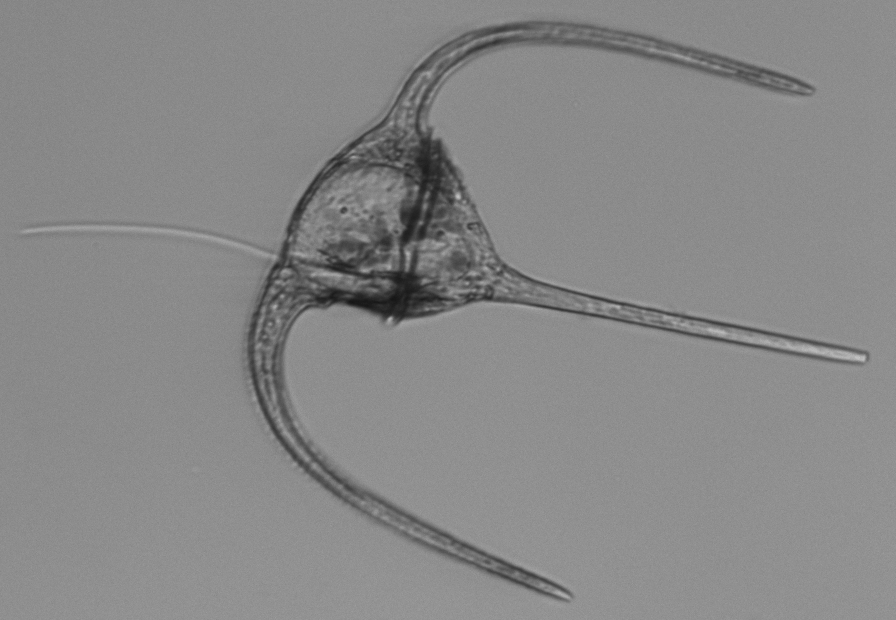

In [8]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths to folders in image_path + */*/*
image_path_list = list(image_path.glob("*/*/*.png")) #glob together all of the files that
#image_path_list #use this to check there are images in paths

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path) #this image.open will error if image is corrupt, can be used for dataset cleaning

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


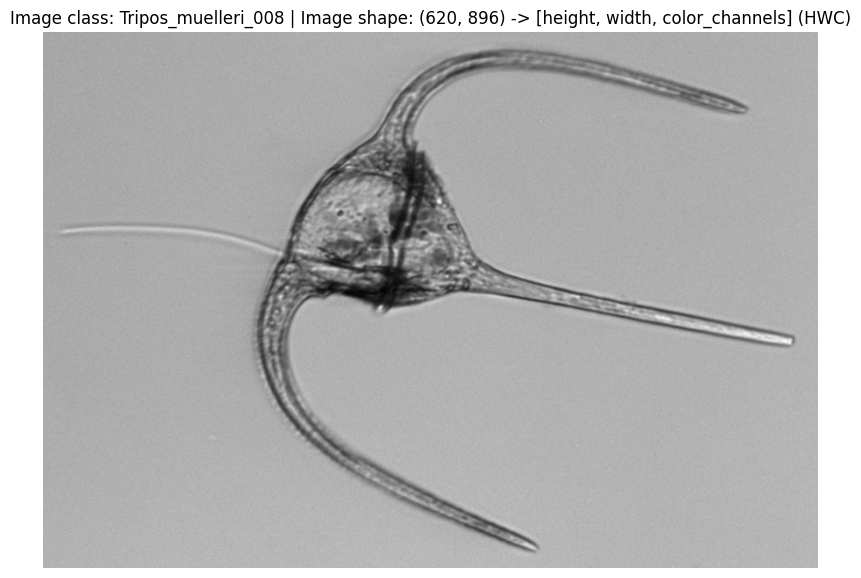

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img, cmap='gray')
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);


3. Transforming data
Before we can use our image data with PyTorch:

Turn your target data into tensors (in our case, numerical representation of our images).
Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with `torchvision.transforms`
Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [11]:
# Write a transform for image size
data_transform = transforms.Compose([ # can also use nn.Sequential for this
  # Resize our images to 64x64 or 244 244
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([1, 64, 64])

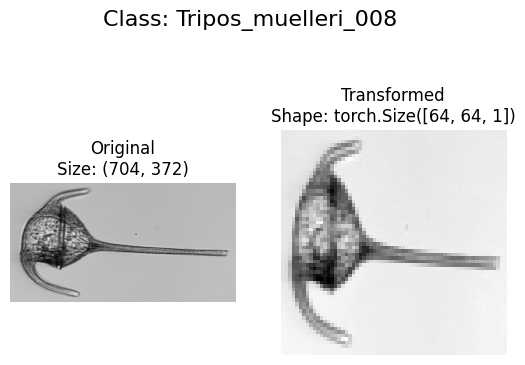

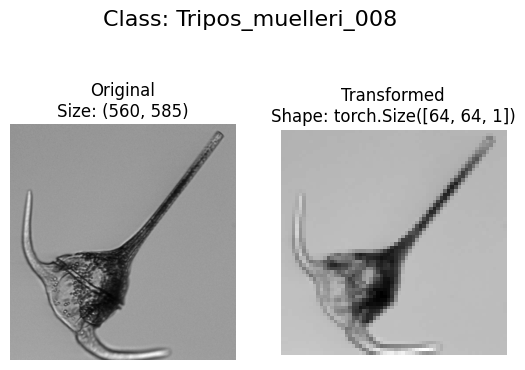

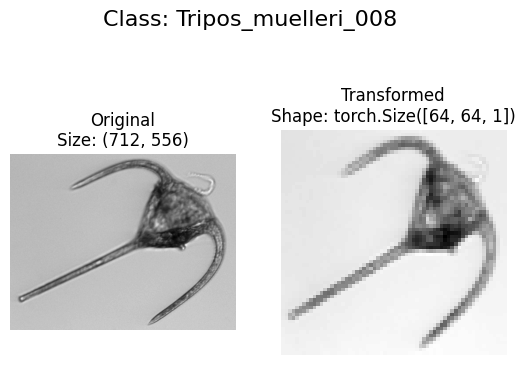

In [13]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f: #using PIL
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f, cmap='gray')
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # permute used for converting colorchannels from first to last to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image, cmap='gray')
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off") #can also write False

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)



### 4. Option 1: Loading image data using ImageFolder
We can load image classification data using torchvision.datasets.ImageFolder - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder



In [14]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, #pass in root, transform, target
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 210
     Root location: data/IFCB_test_train/Train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 42
     Root location: data/IFCB_test_train/Test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
train_dir, test_dir

(PosixPath('data/IFCB_test_train/Train'),
 PosixPath('data/IFCB_test_train/Test'))

In [16]:
# Get class names as list
class_names = train_data.classes
class_names

['Chaetoceros_decipiens_118',
 'Guinardia_delicatula_095',
 'Tripos_muelleri_008']

In [17]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'Chaetoceros_decipiens_118': 0,
 'Guinardia_delicatula_095': 1,
 'Tripos_muelleri_008': 2}

In [18]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(210, 42)

In [55]:

train_data.samples[0]
# data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230513T125547_IFCB139_00024.png', 0) 0=labels (None in target_transform)

('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230513T125547_IFCB139_00024.png',
 0)

In [20]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.5686, 0.5569, 0.5373,  ..., 0.5686, 0.5686, 0.5725],
         [0.5373, 0.5647, 0.5608,  ..., 0.5686, 0.5725, 0.5686],
         [0.5529, 0.5373, 0.5608,  ..., 0.5725, 0.5686, 0.5686],
         ...,
         [0.5961, 0.5961, 0.5961,  ..., 0.5922, 0.5961, 0.5961],
         [0.5961, 0.5961, 0.5961,  ..., 0.5961, 0.5961, 0.5961],
         [0.5961, 0.6000, 0.6000,  ..., 0.5961, 0.5922, 0.5961]],

        [[0.5686, 0.5569, 0.5373,  ..., 0.5686, 0.5686, 0.5725],
         [0.5373, 0.5647, 0.5608,  ..., 0.5686, 0.5725, 0.5686],
         [0.5529, 0.5373, 0.5608,  ..., 0.5725, 0.5686, 0.5686],
         ...,
         [0.5961, 0.5961, 0.5961,  ..., 0.5922, 0.5961, 0.5961],
         [0.5961, 0.5961, 0.5961,  ..., 0.5961, 0.5961, 0.5961],
         [0.5961, 0.6000, 0.6000,  ..., 0.5961, 0.5922, 0.5961]],

        [[0.5686, 0.5569, 0.5373,  ..., 0.5686, 0.5686, 0.5725],
         [0.5373, 0.5647, 0.5608,  ..., 0.5686, 0.5725, 0.5686],
         [0.5529, 0.5373, 0.5608,  ..., 0.5

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'Chaetoceros_decipiens_118')

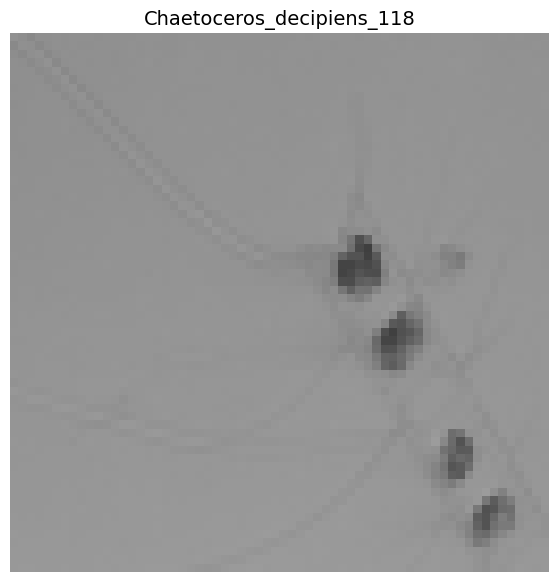

In [21]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)


### 4.1 Turn loaded images into DataLoader's
A DataLoader is going to help us turn our Dataset's into iterables and we can
customise the batch_size so our model can see batch_size images at a time.

* The dataloader sends data in as batches so we dont run out of memory


In [22]:
import os
os.cpu_count()

2

In [23]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1 #(32 is a good batch size)
train_dataloader = DataLoader(dataset=train_data, #pass in a dataset
                              batch_size=BATCH_SIZE,
                              num_workers=1, #num_workers=os.cpu_count() to dedicate more cpu's
                              shuffle=True) #dont want it to recognize an order

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) #to have test data in same order for evaluation purposes

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e6b8168aa10>,
 <torch.utils.data.dataloader.DataLoader at 0x7e6b817bc0a0>)

In [24]:
len(train_dataloader), len(test_dataloader)

(210, 42)

In [25]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom Dataset
1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-built Dataset functions

Cons:
* Even though you could create Dataset out of almost anything, it doesn't mean it will work...
* Using a custom Dataset often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset


In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx


(['Chaetoceros_decipiens_118',
  'Guinardia_delicatula_095',
  'Tripos_muelleri_008'],
 {'Chaetoceros_decipiens_118': 0,
  'Guinardia_delicatula_095': 1,
  'Tripos_muelleri_008': 2})

### 5.1 Creating a helper function to get class names
We want a function to:
1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [28]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/IFCB_test_train/Train


['Chaetoceros_decipiens_118',
 'Guinardia_delicatula_095',
 'Tripos_muelleri_008']

In [29]:
list(os.scandir(target_directory))

[<DirEntry 'Chaetoceros_decipiens_118'>,
 <DirEntry 'Tripos_muelleri_008'>,
 <DirEntry 'Guinardia_delicatula_095'>]

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx



In [56]:
find_classes(target_directory)

(['Chaetoceros_decipiens_118',
  'Guinardia_delicatula_095',
  'Tripos_muelleri_008'],
 {'Chaetoceros_decipiens_118': 0,
  'Guinardia_delicatula_095': 1,
  'Tripos_muelleri_008': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder
To create our own custom dataset, we want to:

1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
* paths - paths of our images
* transform - the transform we'd like to use
* classes - a list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load_images(), this function will open an image
5. Overwrite the __len()__ method to return the length of our dataset
6. Overwrite the __getitem()__ method to return a given sample when passed an index
                                              

In [41]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.png"))
    # Setup transform
    self.transform = transform #set to None up in init
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label


In [42]:
img, label = train_data[0]


In [43]:
img, label

(tensor([[[0.5686, 0.5569, 0.5373,  ..., 0.5686, 0.5686, 0.5725],
          [0.5373, 0.5647, 0.5608,  ..., 0.5686, 0.5725, 0.5686],
          [0.5529, 0.5373, 0.5608,  ..., 0.5725, 0.5686, 0.5686],
          ...,
          [0.5961, 0.5961, 0.5961,  ..., 0.5922, 0.5961, 0.5961],
          [0.5961, 0.5961, 0.5961,  ..., 0.5961, 0.5961, 0.5961],
          [0.5961, 0.6000, 0.6000,  ..., 0.5961, 0.5922, 0.5961]],
 
         [[0.5686, 0.5569, 0.5373,  ..., 0.5686, 0.5686, 0.5725],
          [0.5373, 0.5647, 0.5608,  ..., 0.5686, 0.5725, 0.5686],
          [0.5529, 0.5373, 0.5608,  ..., 0.5725, 0.5686, 0.5686],
          ...,
          [0.5961, 0.5961, 0.5961,  ..., 0.5922, 0.5961, 0.5961],
          [0.5961, 0.5961, 0.5961,  ..., 0.5961, 0.5961, 0.5961],
          [0.5961, 0.6000, 0.6000,  ..., 0.5961, 0.5922, 0.5961]],
 
         [[0.5686, 0.5569, 0.5373,  ..., 0.5686, 0.5686, 0.5725],
          [0.5373, 0.5647, 0.5608,  ..., 0.5686, 0.5725, 0.5686],
          [0.5529, 0.5373, 0.5608,  ...,

In [44]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),#everything between resize and totensor is augmentations
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64, 64)),#usually no augmentation on testdata
                                      transforms.ToTensor()
])

In [45]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)


In [46]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7e6b81531780>,
 <__main__.ImageFolderCustom at 0x7e6b81533010>)

In [47]:

len(train_data), len(train_data_custom)

(210, 210)

In [48]:
len(test_data), len(test_data_custom)

(42, 42)

In [49]:
train_data_custom.classes

['Chaetoceros_decipiens_118',
 'Guinardia_delicatula_095',
 'Tripos_muelleri_008']

In [50]:
train_data_custom.class_to_idx

{'Chaetoceros_decipiens_118': 0,
 'Guinardia_delicatula_095': 1,
 'Tripos_muelleri_008': 2}

In [51]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images
1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)


In [52]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes: #if classes variable exists
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


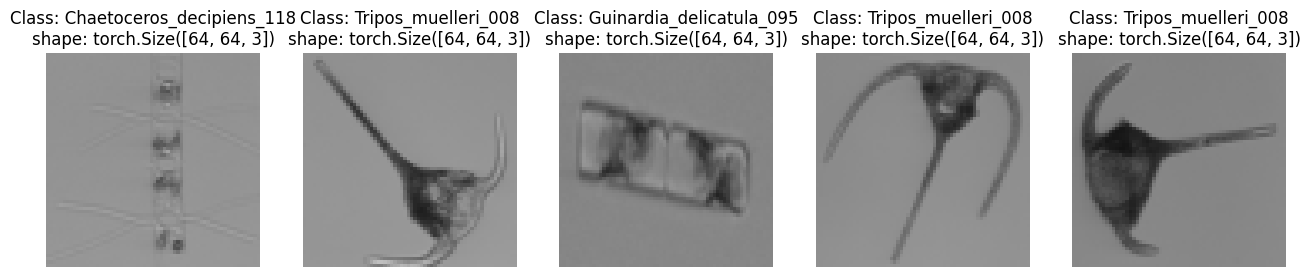

In [53]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)


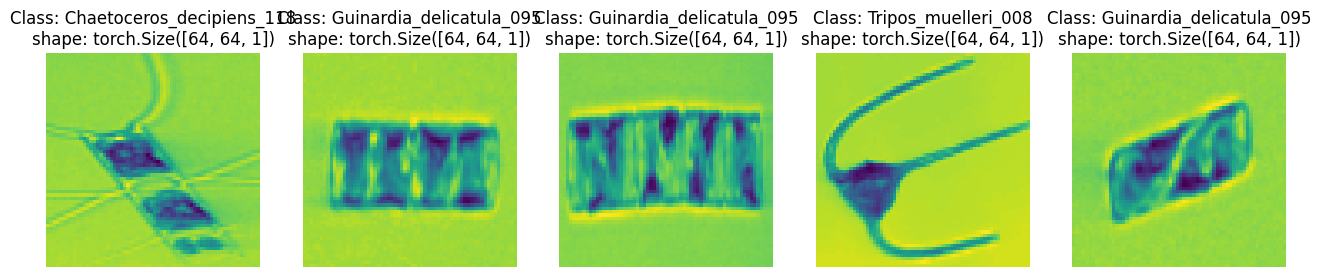

In [54]:
# Display random images from the ImageFolderCustom Dataset
# Need to recode to not get green images...
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)


### 5.4 Turn custom loaded images into DataLoader's

In [57]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e6b80392080>,
 <torch.utils.data.dataloader.DataLoader at 0x7e6b80392980>)

In [58]:
# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape
#->(torch.Size([batch size, colorchannels, 64, 64]), torch.Size([1]))

(torch.Size([1, 1, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [59]:
# Let's look at trivailaugment - https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])


In [60]:
image_path

PosixPath('data/IFCB_test_train')

In [62]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.png"))
image_path_list[:10]

[PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230515T072806_IFCB139_00004.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230515T091056_IFCB139_00068.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20231016T155931_IFCB139_00030.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230513T171252_IFCB139_00002.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230513T134712_IFCB139_00034.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230513T134712_IFCB139_00022.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230515T091056_IFCB139_00014.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20231024T171743_IFCB139_00127.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D20230515T091056_IFCB139_00026.png'),
 PosixPath('data/IFCB_test_train/Train/Chaetoceros_decipiens_118/D2023051

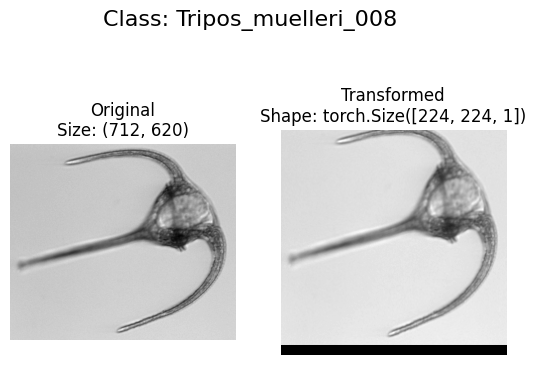

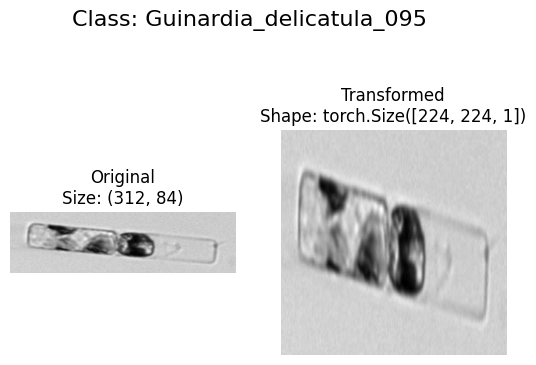

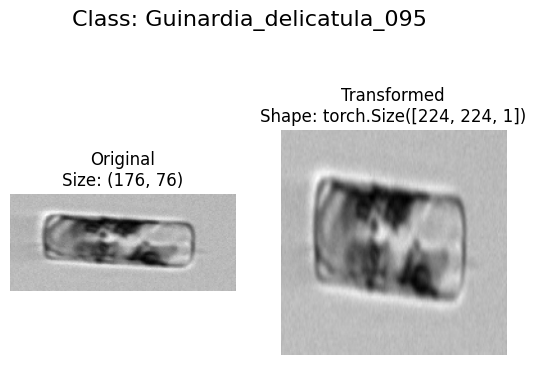

In [63]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation
Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [64]:
# Create simple transform
simple_transform = transforms.Compose([
                                       transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()
])

In [65]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [72]:
#This will error: make new one below after 7.3
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units, #start with in_features=hidden_units, then let the error tell you numbers should be***
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    print(x.shape)
    x = self.conv_block_2(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape) #this is where the shape will error
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html


In [73]:

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

Passing some dummy data through our model to see where its wrong***
`nn.Linear(in_features=hidden_units***`, #start with in_features=hidden_units, then let the error tell you numbers should be***


In [74]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [75]:
# Try a forward pass
model_0(image_batch.to(device))
#->torch.Size([32, 10, 30, 30])
#->torch.Size([32, 10, 13***, 13***]) ERROR SHOWS SHAPE

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3)

In [76]:
#Getting RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690*** and 10x3)
10*13*13 #from the printout: torch.Size([32, 10, 13, 13])
#->1690

1690

In [77]:
# Corrected model
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, #start with in_features=hidden_units, then let the error tell you numbers should be***
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    print(x.shape)
    x = self.conv_block_2(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape) #this is where the shape will error
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html


In [78]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [79]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [80]:
# Try a forward pass
model_0(image_batch.to(device))
#->torch.Size([32, 10, 30, 30])
#->torch.Size([32, 10, 13***, 13***]) ERROR SHOWS SHAPE

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.0054e-02, -9.0874e-04,  1.0480e-02],
        [ 2.0505e-02, -7.4038e-04,  9.3066e-03],
        [ 1.9987e-02,  4.7608e-04,  9.2116e-03],
        [ 1.9645e-02, -4.5067e-04,  9.7527e-03],
        [ 1.9487e-02,  2.1126e-05,  9.0857e-03],
        [ 1.9858e-02, -5.2324e-04,  1.0030e-02],
        [ 1.9902e-02, -8.6970e-04,  9.5827e-03],
        [ 1.9353e-02,  1.0292e-03,  9.1096e-03],
        [ 1.9903e-02, -7.9024e-04,  9.7708e-03],
        [ 1.9502e-02,  4.2581e-04,  8.8277e-03],
        [ 1.9682e-02, -3.9190e-04,  9.0584e-03],
        [ 2.0171e-02,  2.0713e-05,  8.9854e-03],
        [ 2.0108e-02, -8.7428e-04,  9.7368e-03],
        [ 2.0825e-02, -2.8289e-04,  9.3204e-03],
        [ 2.0350e-02,  4.7915e-04,  9.2956e-03],
        [ 1.9462e-02, -1.6304e-03,  9.2040e-03],
        [ 2.0562e-02, -4.1313e-04,  8.7967e-03],
        [ 2.0650e-02, -6.2745e-04,  9.4150e-03],
        [ 2.0044e-02,  3.7054e-04,  1.0177e-02],
        [ 1.9860e-02, -4.8125e-04,  8.9476e-03],
        [ 1.9829e-02

## 7.4 Use torchinfo to get an idea of the shapes going through our model

In [81]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])


torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops functions
* train_step() - takes in a model and dataloader and trains the model on the dataloader.
* test_step() - takes in a model and dataloader and evaluates the model on the dataloader.

In [82]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc



In [83]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item() #accumulate the loss

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

## 7.6 Creating a train() function to combine train_step() and test_step()

In [85]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## 7.7 Train and evaluate model 0

In [86]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([18, 10, 30, 30])
torch.Size([18, 10, 13, 13])
torch.Size([18, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([10, 10, 30, 30])
torch.Size([10, 10, 13, 13])
torch.Size([10, 3])
Epoch: 0 | Train loss: 1.1036 | Train acc: 0.2922 | Test loss: 1.0896 | Test acc: 0.5625
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 

In [87]:
model_0_results

{'train_loss': [1.1036313431603568,
  1.1013243368693761,
  1.0953733239855086,
  1.090831722532,
  1.0735549415860857],
 'train_acc': [0.29216269841269843,
  0.310515873015873,
  0.4141865079365079,
  0.3625992063492064,
  0.6597222222222222],
 'test_loss': [1.0895705819129944,
  1.1119452714920044,
  1.0933541059494019,
  1.089313805103302,
  1.0624284148216248],
 'test_acc': [0.5625, 0.21875, 0.21875, 0.5375, 0.44375]}

## 7.8 Plot the loss curves of Model 0

A loss curve is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [88]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [89]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

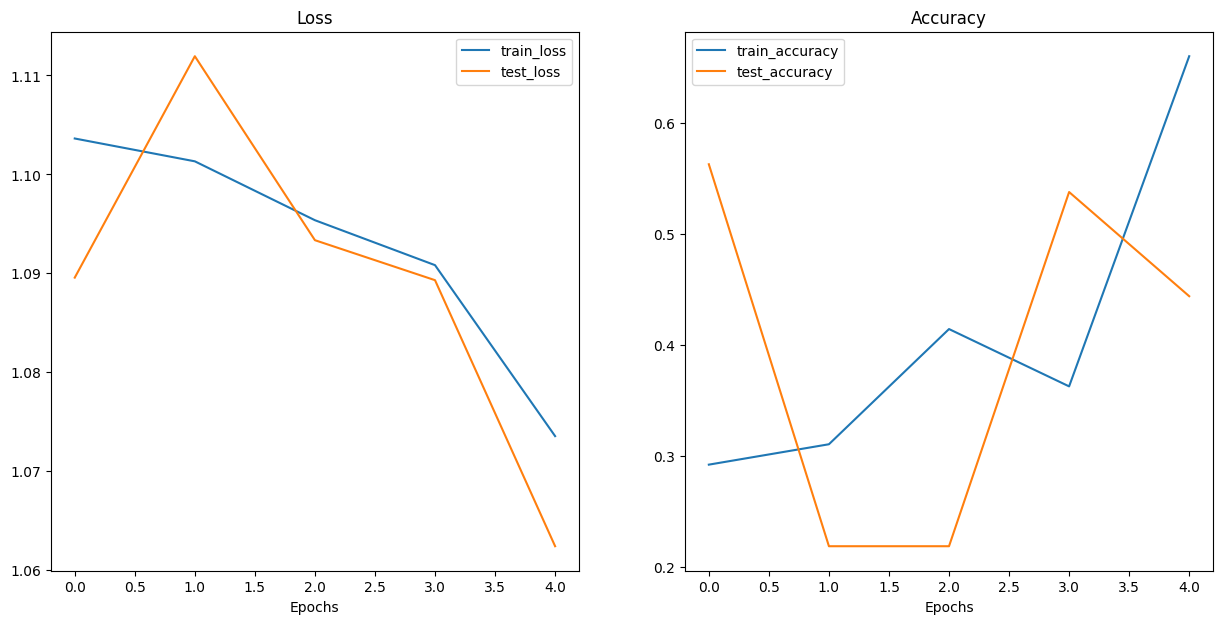

In [90]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?
https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation
Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [91]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

### 9.2 Create train and test Dataset's and DataLoader's with data augmentation

In [92]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)


In [93]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

## 9.3 Construct and train model 1
This time we'll be using the same model architecture except this time we've augmented the training data.

In [94]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Wonderful! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon our train() function to train and evaluate our model.

In [95]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([18, 10, 30, 30])
torch.Size([18, 10, 13, 13])
torch.Size([18, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([10, 10, 30, 30])
torch.Size([10, 10, 13, 13])
torch.Size([10, 3])
Epoch: 0 | Train loss: 1.1047 | Train acc: 0.3051 | Test loss: 1.0885 | Test acc: 0.5625
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 

### 9.4 Plot the loss curves of model 1
A loss curve helps you evaluate your models performance overtime.

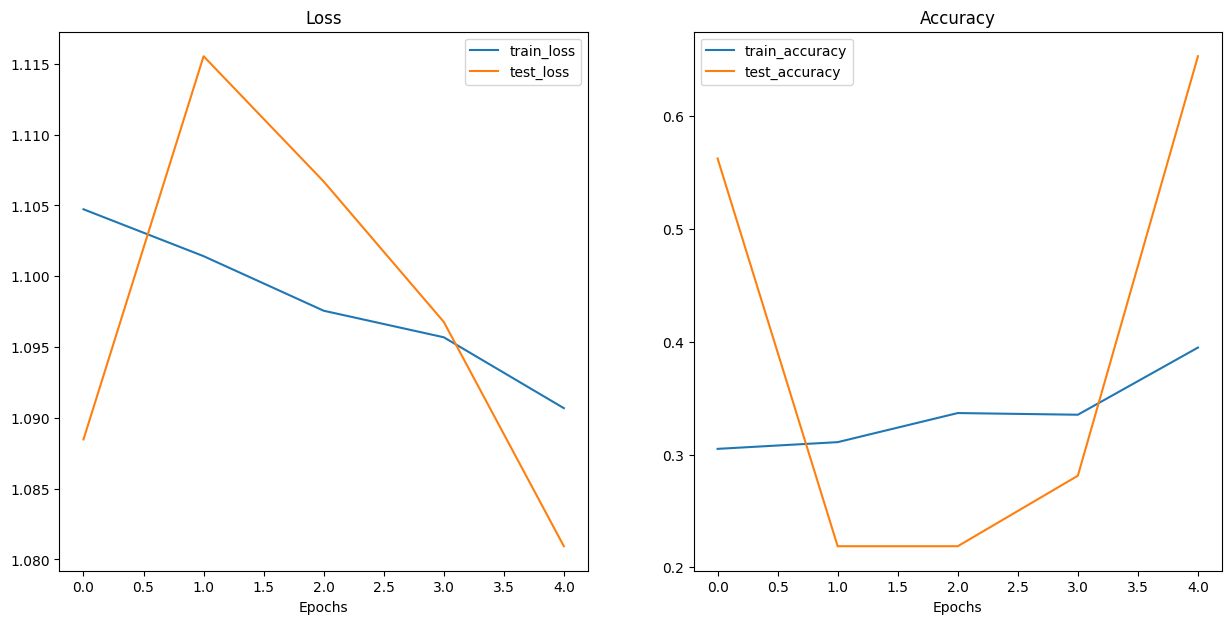

In [96]:
plot_loss_curves(model_1_results)

## 10. Compare model results
After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [97]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.103631,0.292163,1.089571,0.56250
1,1.101324,0.310516,1.111945,0.21875
2,1.095373,0.414187,1.093354,0.21875
3,1.090832,0.362599,1.089314,0.53750
4,1.073555,0.659722,1.062428,0.44375


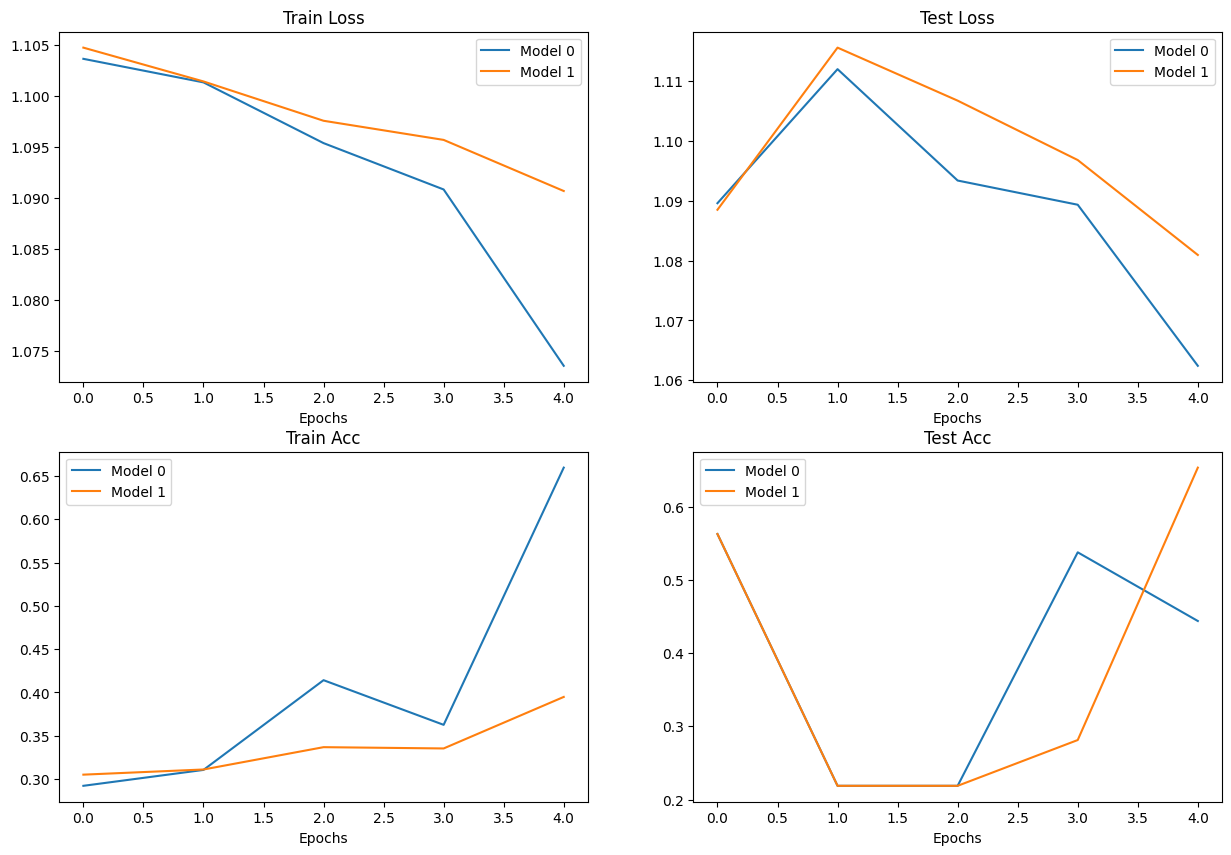

In [98]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image
Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.


In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")